# <center> 🎤 SER Final Project: Emotion Recognition with EmoDB & RAVDESS </center>

---

## 🧠 **Speech Emotion Recognition (SER)**
### Combining **EmoDB** and **RAVDESS** Datasets for Robust Emotion Analysis

🎯 **Objective:** Build a **Speech Emotion Recognition (SER)** system by leveraging two powerful datasets to improve emotion classification from audio signals.

---

## 🌟 **Project Overview**
This project integrates two widely recognized datasets for speech emotion recognition:

- 🎙 **EmoDB**: Berlin Database of Emotional Speech, featuring German speech samples labeled with emotions.
- 🎼 **RAVDESS**: Ryerson Audio-Visual Database of Emotional Speech and Song, consisting of North American English speech and song recordings.

By combining these datasets, we aim to enhance model performance, ensuring better generalization across different speech samples.

---

## 📊 **Emotion Labels Comparison**

| Dataset  | Emotion Labels                                  |
|----------|-----------------------------------------------|
| **EmoDB** | Neutral, Boredom, Happy, Sad, Angry, Fear, Disgust |
| **RAVDESS** | Neutral, Calm, Happy, Sad, Angry, Fearful, Disgust, Surprised |

### 🔹 **Detailed Emotion Mapping:**
#### 📌 **EmoDB Emotion Labels:**
- 😠 **Anger** (Ärger - Wut)
- 😴 **Boredom** (Langeweile)
- 🤢 **Disgust** (Ekel)
- 😨 **Fear** (Angst)
- 😃 **Happiness** (Freude)
- 😢 **Sadness** (Trauer)
- 😐 **Neutral** (Neutral version)

#### 📌 **RAVDESS Emotion Labels:**
- 😐 **Neutral** (01)
- 😌 **Calm** (02)
- 😃 **Happy** (03)
- 😢 **Sad** (04)
- 😠 **Angry** (05)
- 😨 **Fearful** (06)
- 🤢 **Disgust** (07)
- 😲 **Surprised** (08)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/DPL_Project

/content/drive/MyDrive/DPL_Project


In [ ]:
# !/bin/bash
# !curl -L -o berlin-database-of-emotional-speech-emodb.zip\
#   https://www.kaggle.com/api/v1/datasets/download/piyushagni5/berlin-database-of-emotional-speech-emodb
# !unzip /content/drive/MyDrive/DPL_Project/berlin-database-of-emotional-speech-emodb.zip

In [ ]:
# #!/bin/bash
# !curl -L -o vietnamese-speech-labeled-by-region.zip\
#   https://www.kaggle.com/api/v1/datasets/download/trnngci/vietnamese-speech-labeled-by-region
# !unzip vietnamese-speech-labeled-by-region.zip

In [ ]:
!pip install --q librosa
!pip install --q mealpy

import pandas as pd
import numpy as np

import os
import sys
import tensorflow as tf
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelBinarizer
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

# to play the audio files
from IPython.display import Audio

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Dropout, LSTM, Dense

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.3/386.3 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 65.6 MB/s eta 0:00:00


#  <center> 🇩🇪 EmoDB </center>

Emotion Counts:
neutral: 79
disgust: 46
fear: 69
sadness: 62
happiness: 71
anger: 127
boredom: 81


<ipython-input-5-06697247e695>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_order, y=counts, palette="colorblind")


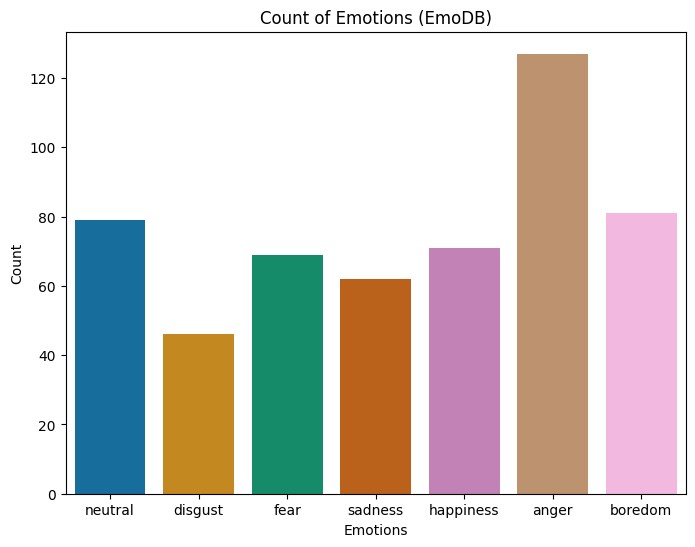

In [ ]:
# Define the dataset directory
emodb_path = "wav/*.wav"

# Mapping EmoDB filename encoding to emotions
emotion_map = {
    'W': 'anger',
    'L': 'boredom',
    'E': 'disgust',
    'A': 'fear',
    'F': 'happiness',
    'T': 'sadness',
    'N': 'neutral'
}

# Extract emotion labels from filenames
filenames = glob.glob(emodb_path)
emotions = [emotion_map[os.path.basename(f)[5]] for f in filenames if os.path.basename(f)[5] in emotion_map]

# Count occurrences of each emotion
emotion_counts = Counter(emotions)

# Sort emotions by predefined order
emotion_order = ['neutral', 'disgust', 'fear', 'sadness', 'happiness', 'anger', 'boredom']
counts = [emotion_counts[e] for e in emotion_order if e in emotion_counts]

# Print the count of each emotion
print("Emotion Counts:")
for emotion in emotion_order:
    count = emotion_counts.get(emotion, 0)  # Get the count or default to 0 if emotion is not found
    print(f"{emotion}: {count}")

# Plot the emotion distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=emotion_order, y=counts, palette="colorblind")
plt.xlabel("Emotions")
plt.ylabel("Count")
plt.title("Count of Emotions (EmoDB)")
plt.show()

In [ ]:
Emo_df = pd.DataFrame({
    'filenames': filenames,
    'emotions': emotions
})
Emo_df.head()

,filenames,emotions
0,wav/03a01Nc.wav,neutral
1,wav/03a01Wa.wav,anger
2,wav/03a02Wb.wav,anger
3,wav/03a02Nc.wav,neutral
4,wav/03a02Fc.wav,happiness


In [ ]:
# data_path = Ravdess_df
data_path = Emo_df
# data_path.to_csv("data_path.csv",index=False)

data_path.head()

,filenames,emotions
0,wav/03a01Nc.wav,neutral
1,wav/03a01Wa.wav,anger
2,wav/03a02Wb.wav,anger
3,wav/03a02Nc.wav,neutral
4,wav/03a02Fc.wav,happiness


# <center> 🗑️ Drop Some Categories to Align Labels </center>

---

## <center> **Aligning Emotion Labels Across Datasets** </center>

To ensure consistency between the **RAVDESS** and **EmoDB** datasets, we will streamline the emotion categories by dropping labels that are not shared between the two datasets.

This step is crucial for creating a **unified set of emotion labels**, which will improve the reliability and accuracy of our emotion recognition model.

---

### <center> Let's proceed to align the labels! </center>

In [ ]:
data_path['emotions'].unique()

array(['neutral', 'anger', 'happiness', 'sadness', 'boredom', 'fear',
       'disgust'], dtype=object)

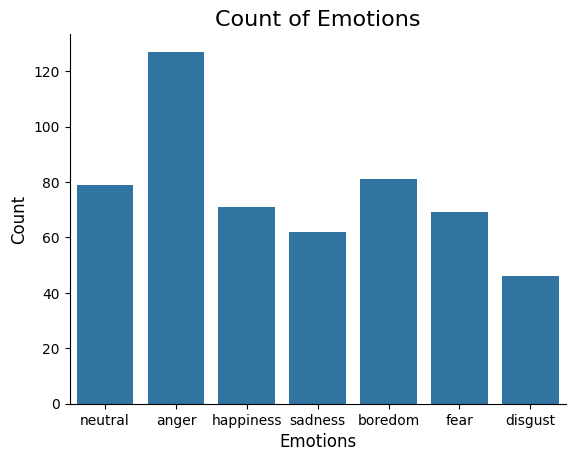

Counter({'neutral': 79,
         'anger': 127,
         'happiness': 71,
         'sadness': 62,
         'boredom': 81,
         'fear': 69,
         'disgust': 46})

In [ ]:
# Set the title and labels
plt.title('Count of Emotions', size=16)

# Plot the count of emotions
sns.countplot(x=data_path['emotions'])  # Use x= to specify the column

# Add axis labels
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)

# Remove unnecessary spines
sns.despine(top=True, right=True, left=False, bottom=False)

# Display the plot
plt.show()
Counter(data_path['emotions'])

# <center> 📊 Visualization of Audio Features for Emotion Analysis </center>

---

## <center> **Exploring Audio Characteristics Across Emotions** </center>

In this section, we delve into the audio features of our dataset to gain insights into how different emotions are represented in the audio signals. By visualizing waveforms, spectrograms, and Mel-Frequency Cepstral Coefficients (MFCCs), we aim to understand the unique characteristics of each emotion.

---

### <center> **Why Visualize Audio Features?** </center>

- **Waveform**: Provides a time-domain view of the audio signal, showing amplitude variations over time.
- **Spectrogram**: Offers a frequency-domain perspective, revealing how the intensity of different frequencies changes over time.
- **MFCCs**: Capture the spectral envelope of the audio, mimicking human perception and serving as a compact representation for machine learning models.

These visualizations help us:
- Identify patterns specific to each emotion.
- Validate the quality of the data.
- Gain intuition about how audio features can be used for emotion recognition.

---

### <center> **Visualization Workflow** </center>

For each emotion in the dataset, we perform the following steps:

1. **Select an Audio Sample**:
   - Filter the dataset for the target emotions.
   - Load the corresponding audio file using `librosa`.

2. **Generate Waveform**:
   - Plot the waveform to observe amplitude changes over time.
   - Example: A steady waveform with minimal fluctuations may indicate a calm or neutral emotion.

3. **Generate Spectrogram**:
   - Compute the Short-Time Fourier Transform (STFT) to analyze the frequency content of the audio.
   - Visualize the spectrogram to identify dominant frequencies and their temporal evolution.
   - Example: Voiced sounds appear as bright vertical bands, while silence or unvoiced sounds appear as dark regions.

4. **Generate MFCCs**:
   - Extract MFCCs to represent the spectral envelope of the audio.
   - Visualize the MFCCs to observe how the coefficients vary over time.
   - Example: MFCCs provide a compact representation that captures the most relevant features for emotion classification.

5. **Play the Audio**:
   - Use the `Audio` function to listen to the selected sample and correlate the sound with its visual representation.

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveform for audio with emotion {}'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft performs Fourier transform.
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with emotion {}'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
def create_mfcc(data, sr, e):
    mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13)
    plt.figure(figsize=(12, 3))
    plt.title('Mel-frequency cepstral coefficient for audio with emotion {}'.format(e), size=15)
    librosa.display.specshow(mfcc, x_axis='time')
    plt.ylabel('MFCC')
    plt.colorbar()

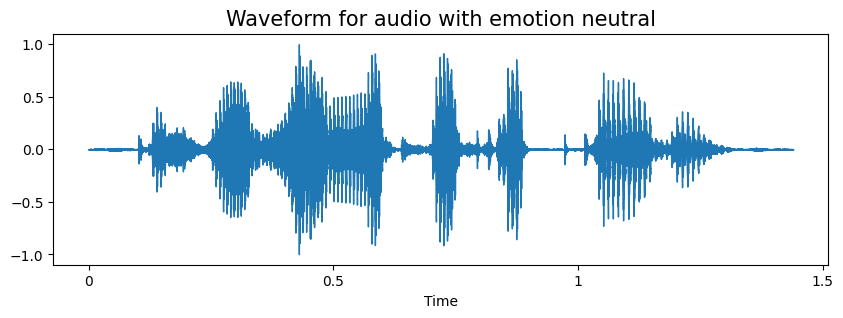

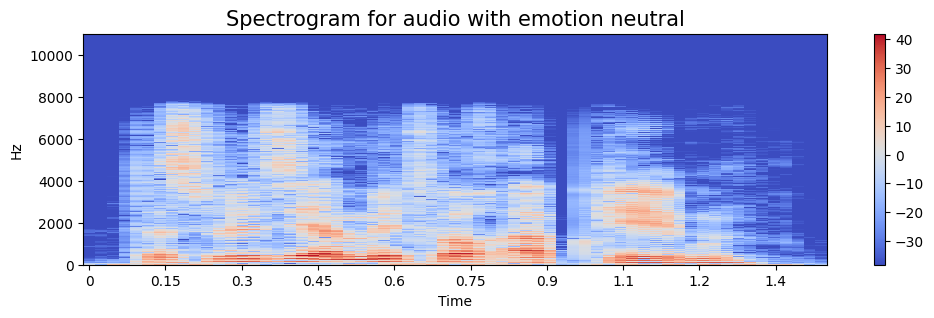

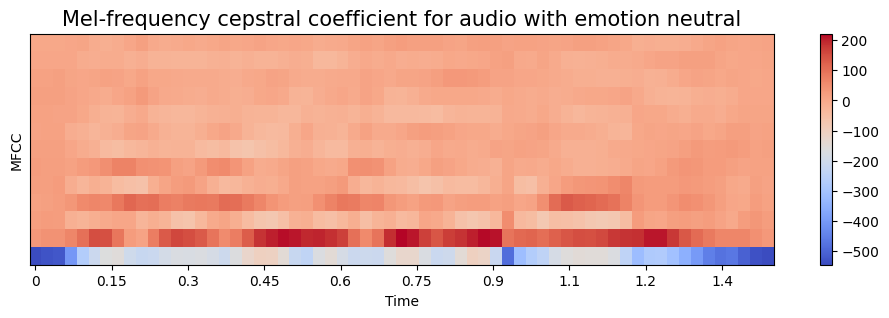

In [ ]:
emotion = 'neutral'
path = np.array(data_path.filenames[data_path.emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_mfcc(data, sampling_rate, emotion)
Audio(path)

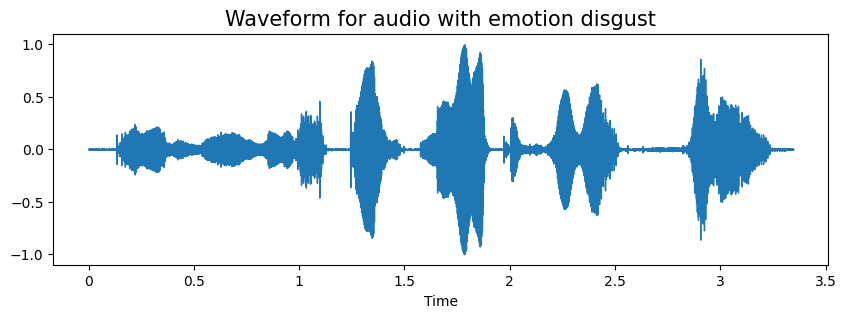

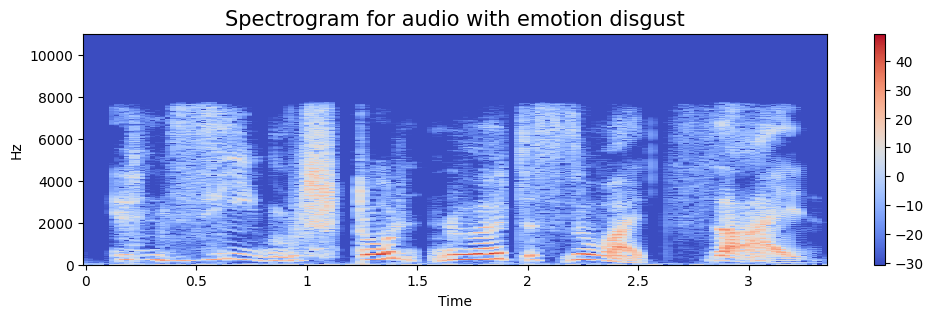

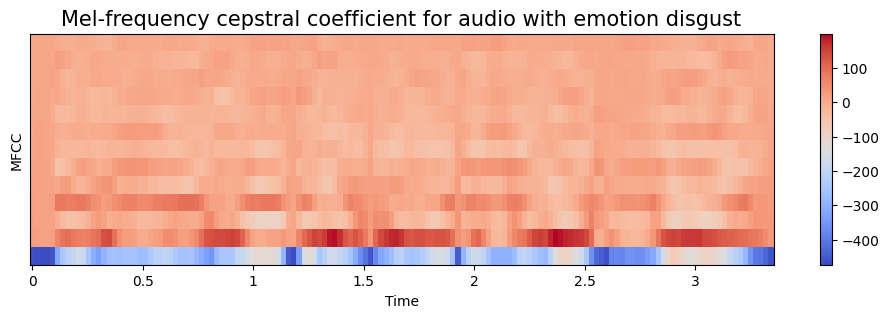

In [ ]:
emotion = 'disgust'
path = np.array(data_path.filenames[data_path.emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_mfcc(data, sampling_rate, emotion)
Audio(path)

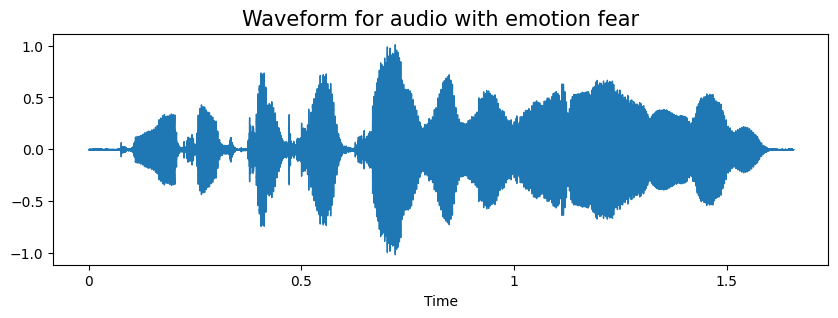

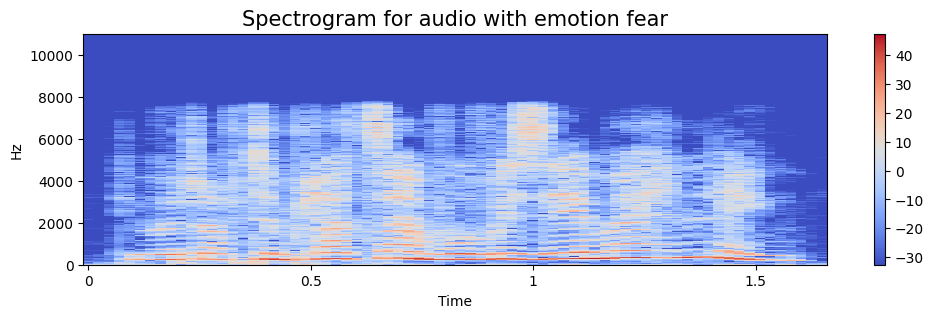

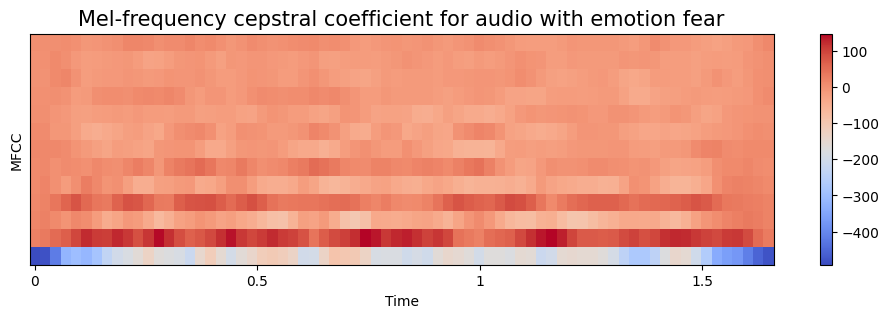

In [ ]:
emotion = 'fear'
path = np.array(data_path.filenames[data_path.emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_mfcc(data, sampling_rate, emotion)
Audio(path)

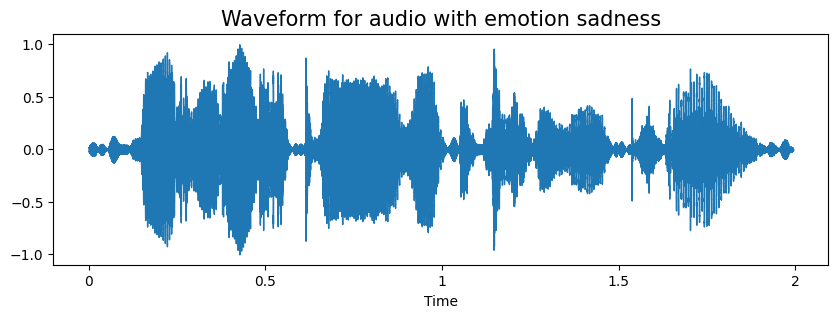

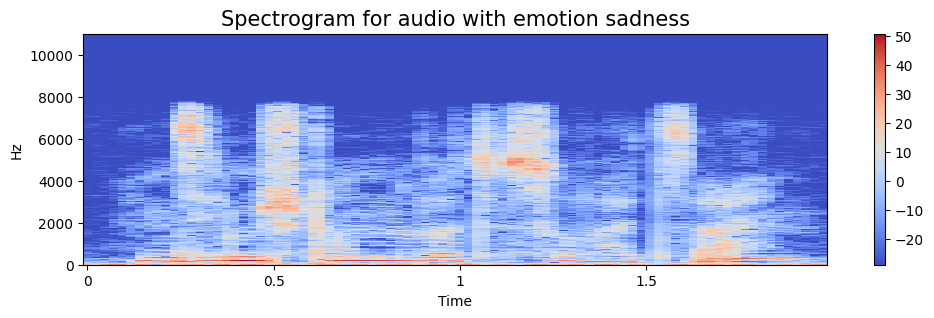

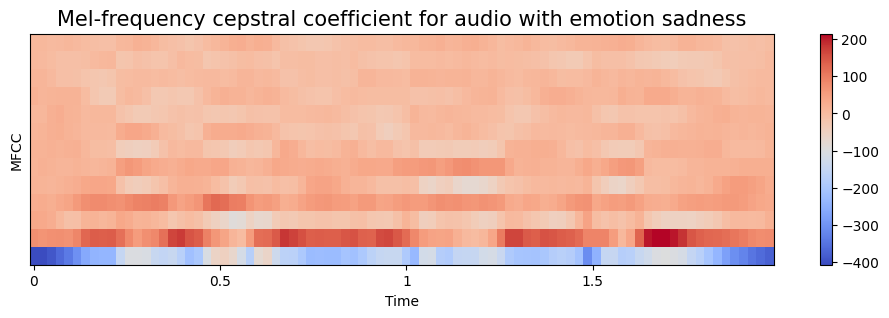

In [ ]:
emotion = 'sadness'
path = np.array(data_path.filenames[data_path.emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_mfcc(data, sampling_rate, emotion)
Audio(path)

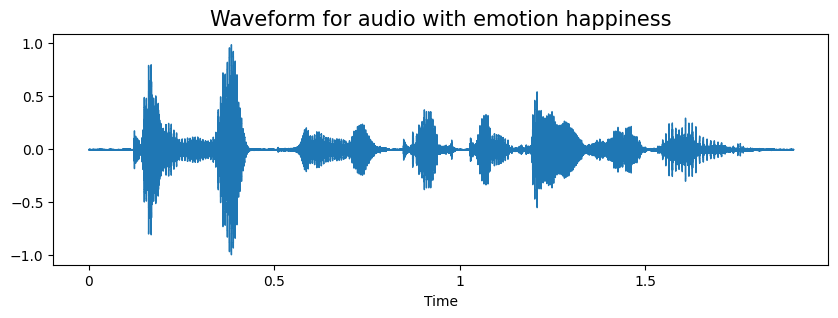

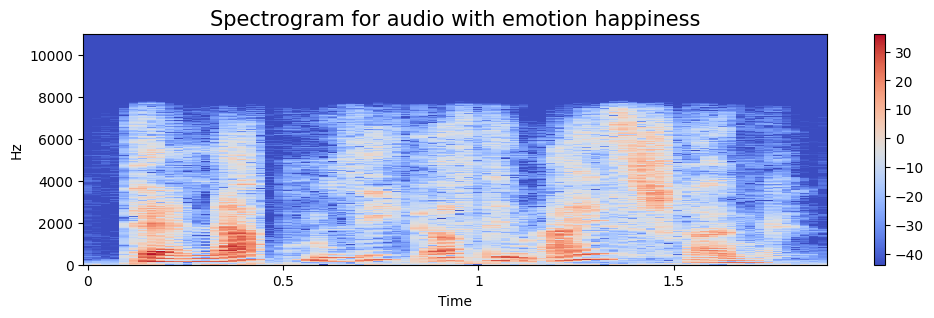

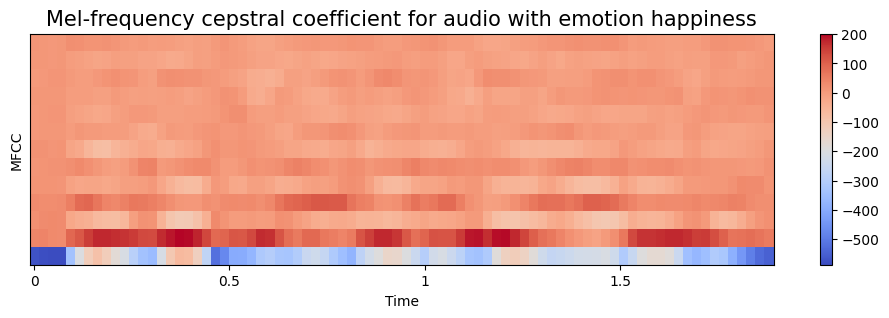

In [ ]:
emotion = 'happiness'
path = np.array(data_path.filenames[data_path.emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_mfcc(data, sampling_rate, emotion)
Audio(path)

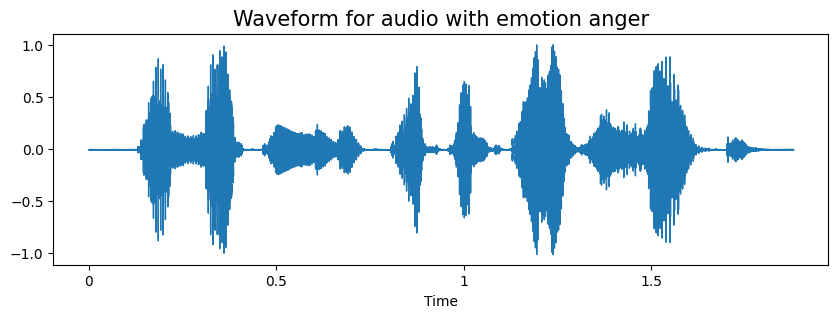

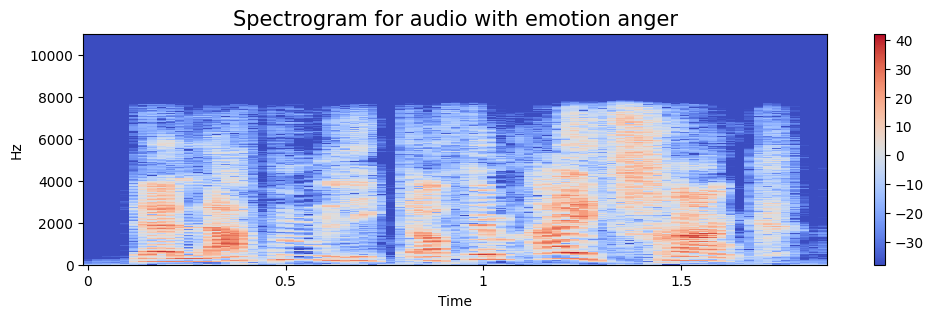

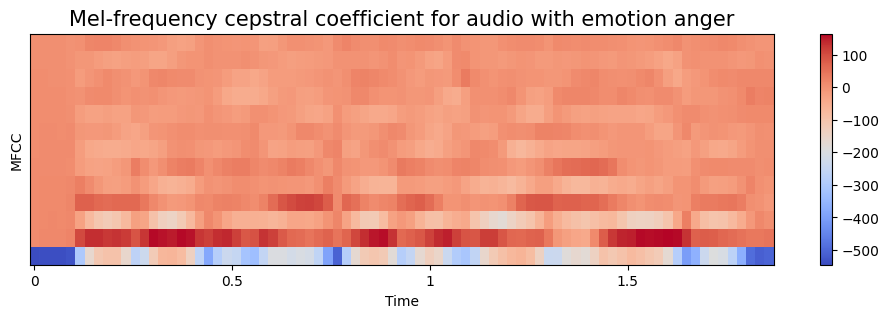

In [ ]:
emotion = 'anger'
path = np.array(data_path.filenames[data_path.emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_mfcc(data, sampling_rate, emotion)
Audio(path)

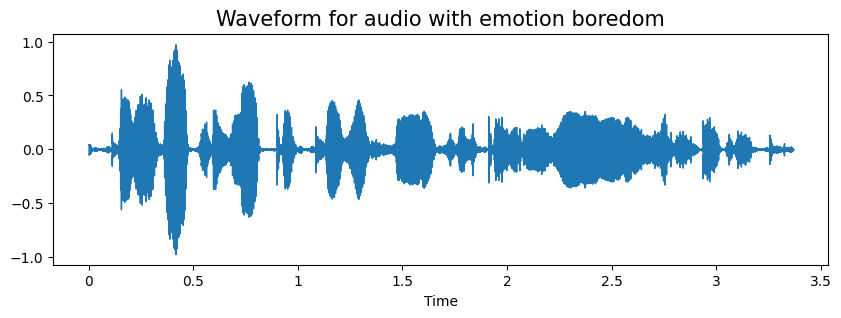

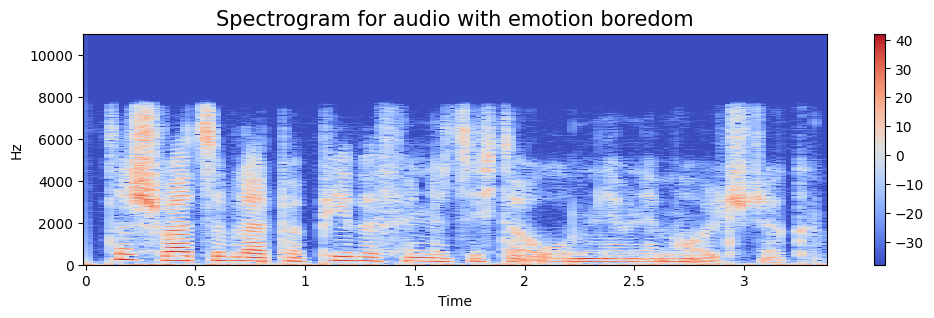

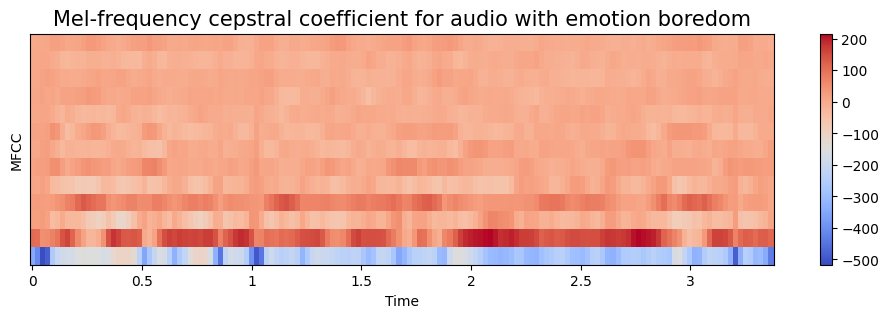

In [ ]:
emotion = 'boredom'
path = np.array(data_path.filenames[data_path.emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_mfcc(data, sampling_rate, emotion)
Audio(path)

# <center> 🎵 Data Augmentations: Enhancing Audio Diversity </center>

---

## <center> **Exploring Augmentation Techniques** </center>

In this section, we explore various data augmentation techniques to enhance the diversity of our audio dataset. These augmentations simulate real-world variations in audio signals, making our emotion recognition model more robust and generalizable.

Each augmentation is visualized and explained below:

---

### <center> **1. Normal Sound 🎤** </center>

- Represents the original, unmodified audio signal.
- No transformations are applied.
- This serves as the baseline for comparison with augmented versions.

#### **Key Characteristics**:
- Clean and unaltered waveform.
- Captures the natural characteristics of the audio.

---

### <center> **2. Noise Injection 🔊⚡** </center>

- Adds random background noise to the audio signal.
- Simulates real-world scenarios where background noise (e.g., traffic, crowd chatter) might be present.

#### **Why Use It?**
- Helps the model generalize to noisy environments.
- Improves robustness against imperfect audio inputs.

---

### <center> **3. Time Stretching ⏩⏪** </center>

- Stretches or compresses the audio signal without altering its pitch.
- Simulates variations in speaking speed (e.g., faster or slower speech).

#### **Why Use It?**
- Captures temporal variations in speech patterns.
- Useful for handling speakers who talk at different speeds.

---

### <center> **4. Pitch Shifting 🎶↕️** </center>

- Shifts the pitch of the audio signal up or down by a specified number of semitones.
- Simulates variations in vocal tone (e.g., higher-pitched or lower-pitched voices).

#### **Why Use It?**
- Accounts for differences in speaker gender, age, or emotional intensity.
- Enhances the model's ability to recognize emotions across diverse vocal tones.


In [ ]:
# Define augmentation functions
def noise(data, noise_rate=0.05):
    noise_amp = noise_rate * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.9):
    return librosa.effects.time_stretch(data, rate=rate)

def pitch_shift(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

# Load an example audio file
path = np.array(data_path.filenames)[2]
data, sample_rate = librosa.load(path)

# Apply augmentations
x_stretched = stretch(data)
x_pitch_shifted = pitch_shift(data, sample_rate)

## <center> **1. Normal Sound 🎤** </center>

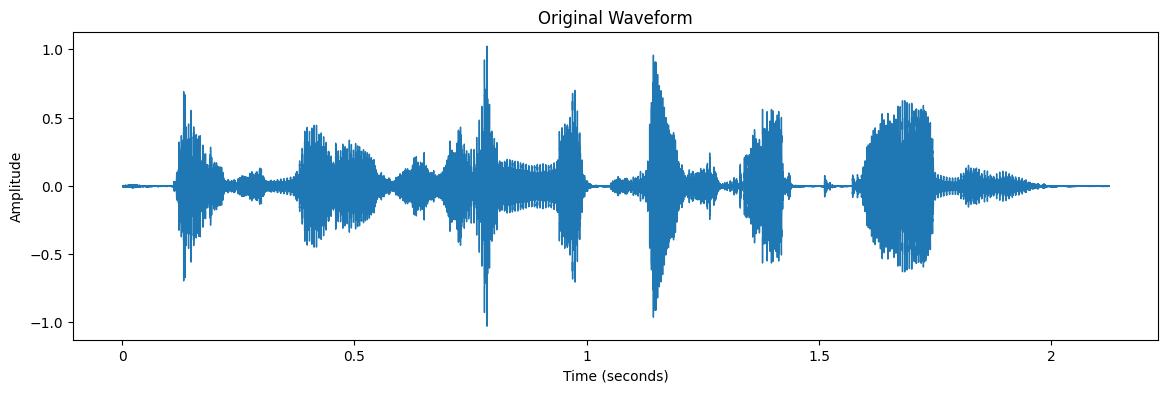

In [ ]:
# Plot the original waveform
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=data, sr=sample_rate)
plt.title("Original Waveform")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

# Play the original audio
Audio(data, rate=sample_rate)

## <center> **2. Noise Injection 🔊⚡** </center>

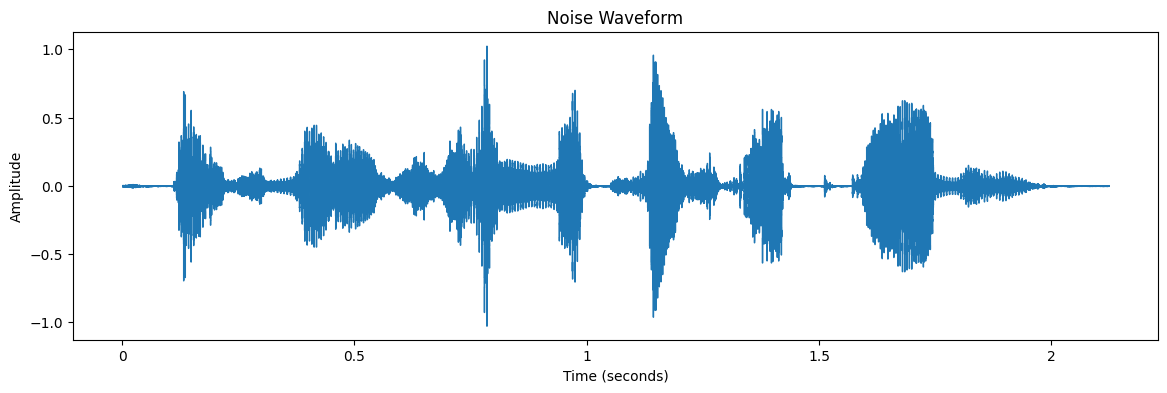

In [ ]:
x = noise(data)

# Load the audio file
data, sample_rate = librosa.load(path)

# Plot the waveform using waveshow
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=data, sr=sample_rate)
plt.title("Noise Waveform")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

Audio(x, rate=sample_rate)

## <center> **3. Time Stretching ⏩⏪** </center>

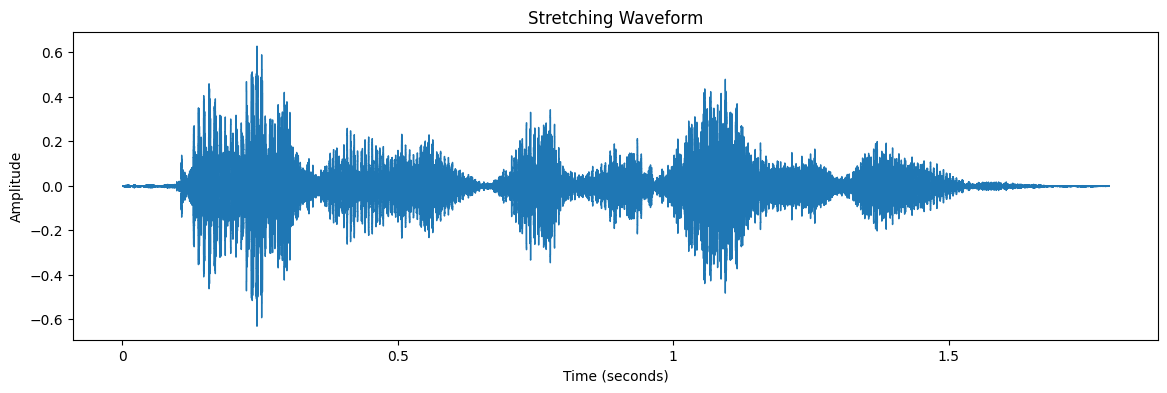

In [ ]:
x = stretch(data)

# Load the audio file
data, sample_rate = librosa.load(path)

# Plot the stretched waveform
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x_stretched, sr=sample_rate)
plt.title("Stretching Waveform")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

Audio(x, rate=sample_rate)

## <center> **4. Pitch Shifting 🎶↕️** </center>

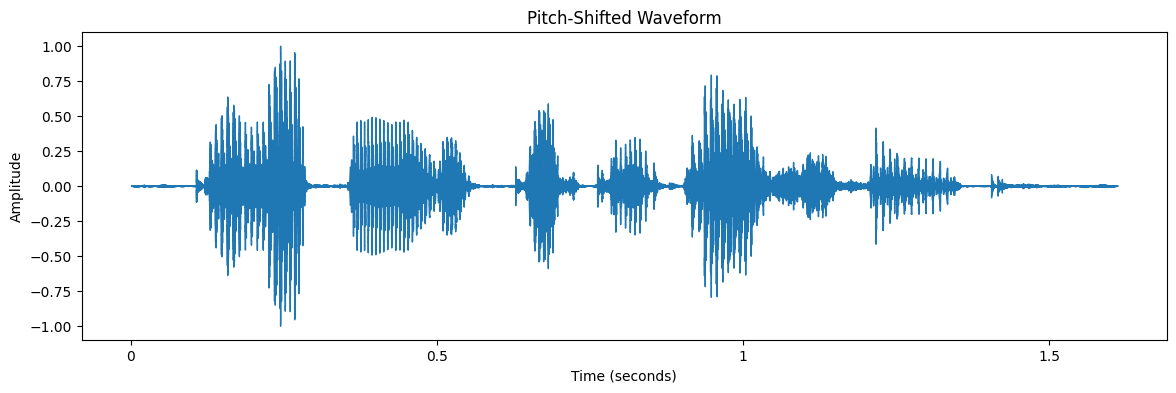

In [ ]:
x_pitch_shifted = pitch_shift(data, sample_rate)

# Load the audio file
data, sample_rate = librosa.load(path)

# Plot the waveform using waveshow
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=data, sr=sample_rate)
plt.title("Pitch-Shifted Waveform")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

Audio(x_pitch_shifted, rate=sample_rate)

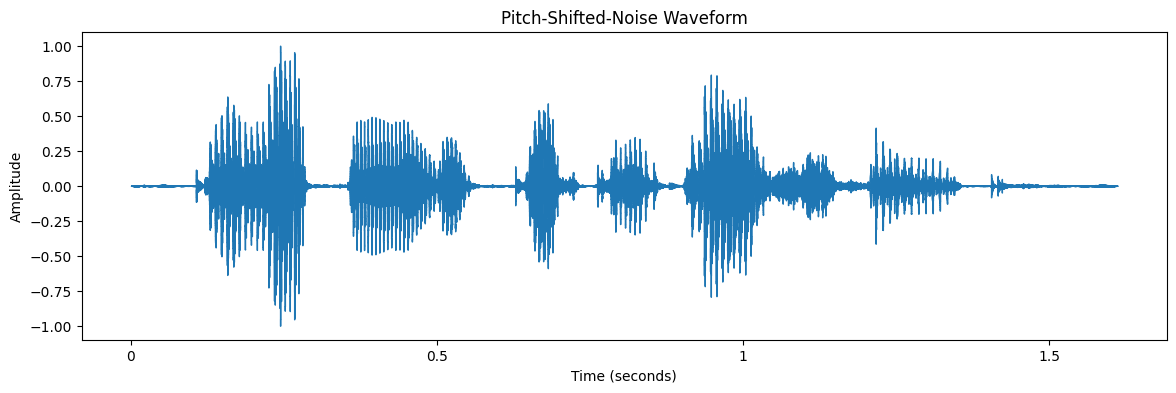

In [ ]:
x_pitch_shifted = pitch_shift(data, sample_rate)

pitched_noise_data = noise(x_pitch_shifted)
# Load the audio file
data, sample_rate = librosa.load(path)
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=data, sr=sample_rate)
plt.title("Pitch-Shifted-Noise Waveform")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

Audio(pitched_noise_data, rate=sample_rate)

In [ ]:
FIXED_LENGTH = 5120


# Zero Crossing Rate
def zcr(data, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)

# RMS Energy
def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

# MFCC
def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)

# Extract features and stack them into a one-dimensional array
def extract_features(data, sr, frame_length=2048, hop_length=512):
    # Fix the length of the audio signal
    data = librosa.util.fix_length(data, size=FIXED_LENGTH)

    # Extract features
    zcr_feature = zcr(data, frame_length, hop_length)
    rmse_feature = rmse(data, frame_length, hop_length)
    mfcc_feature = mfcc(data, sr, frame_length, hop_length)

    # Combine features into a single vector
    result = np.hstack((zcr_feature, rmse_feature, mfcc_feature))
    return result


In [ ]:
# Data augmentation function for the model
def get_features(path):
    # Load audio file
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # Normal data
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # Noise data
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2))

    # Stretched data
    stretched_data = stretch(data)
    res3 = extract_features(stretched_data, sample_rate)
    result = np.vstack((result, res3))

    # Pitch-shifted data
    pitched_data = pitch_shift(data, sample_rate)
    res4 = extract_features(pitched_data, sample_rate)
    result = np.vstack((result, res4))

    # Combined pitch-shifted + noise
    pitched_noise_data = noise(pitched_data)
    res5 = extract_features(pitched_noise_data, sample_rate)
    result = np.vstack((result, res5))

    return result

In [ ]:
X, Y = [], []
for path, emotion in zip(data_path.filenames, data_path.emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # Each data point will be added 4 times due to 4 augmentations (normal, noise, stretch, pitch-shift).
        Y.append(emotion)

# Extract the length of the feature matrix X and label array Y
len(X), len(Y), data_path.filenames.shape

(2675, 2675, (535,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
# Features.to_csv('features.csv', index=False)
print(Features.head(10))

# Features = pd.read_csv('features.csv')
print(Features.shape)

          0         1         2         3         4         5         6  \
0  0.025391  0.035645  0.047852  0.083984  0.083496  0.083496  0.100586   
1  0.120117  0.131348  0.143555  0.105469  0.106934  0.193848  0.213867   
2  0.045410  0.064941  0.079590  0.081055  0.058105  0.054199  0.076660   
3  0.044922  0.063965  0.080078  0.081543  0.062500  0.070312  0.073730   
4  0.208984  0.265137  0.291504  0.201660  0.206055  0.251953  0.311035   
5  0.063965  0.078613  0.109375  0.121582  0.093262  0.099609  0.074707   
6  0.130859  0.214355  0.277344  0.295410  0.340332  0.381836  0.452637   
7  0.066406  0.100098  0.141602  0.151367  0.164551  0.161133  0.129395   
8  0.069336  0.113770  0.154297  0.156250  0.171387  0.146484  0.152344   
9  0.068359  0.112793  0.152344  0.155762  0.173340  0.153320  0.173340   

          7         8         9  ...        233       234        235  \
0  0.068359  0.051270  0.041016  ...  -1.128387  5.351460  -8.756214   
1  0.174805  0.143066  0.04443

In [ ]:
X = Features.iloc[:, :-1].values
Y = Features['labels'].values

# Encode labels for multi-class classification
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1, 1)).toarray()
encoder.categories_

[array(['anger', 'boredom', 'disgust', 'fear', 'happiness', 'neutral',
        'sadness'], dtype=object)]

# <center> 📊Dataset Split </center>
## <center> 80% ✅ : 10%🔍 : 10% 🧪 </center>

In [ ]:
# Convert one-hot encoded labels back to class labels
lb = LabelBinarizer()
y_original = np.argmax(Y, axis=1)

# Split the data into 90% (training + validation) and 10% testing
x_train_val, x_test, y_train_val, y_test = train_test_split(
    X, y_original, test_size=0.1, random_state=42, shuffle=True, stratify=y_original
)

# Print class distribution in the training + validation set before SMOTE
print("\nClass distribution in the training + validation set before SMOTE:")
print(Counter(y_train_val))

# Apply SMOTE to balance the training + validation set
smote = SMOTE(random_state=42)
x_train_val_resampled, y_train_val_resampled = smote.fit_resample(x_train_val, y_train_val)

# Print class distribution in the training + validation set after SMOTE
print("\nClass distribution in the training + validation set after SMOTE:")
print(Counter(y_train_val_resampled))


# Now split the resampled data into 80% training and 10% validation
x_train, x_val, y_train, y_val = train_test_split(
    x_train_val_resampled, y_train_val_resampled, test_size=0.1111, random_state=42, shuffle=True, stratify=y_train_val_resampled
)

# Convert the resampled class labels back to one-hot encoding
y_train_onehot = lb.fit_transform(y_train)
y_val_onehot = lb.transform(y_val)
y_test_onehot = lb.transform(y_test)

# Print the shapes of the datasets before and after SMOTE
print("\nShapes before SMOTE:")
print("Original Training + Validation set:", x_train_val.shape, y_train_val.shape)
print("Testing set:", x_test.shape, y_test.shape)

print("\nShapes after SMOTE:")
print("Resampled Training set:", x_train.shape, y_train_onehot.shape)
print("Validation set:", x_val.shape, y_val_onehot.shape)
print("Testing set:", x_test.shape, y_test_onehot.shape)


Class distribution in the training + validation set before SMOTE:
Counter({0: 571, 1: 364, 5: 355, 4: 320, 3: 311, 6: 279, 2: 207})

Class distribution in the training + validation set after SMOTE:
Counter({0: 571, 6: 571, 5: 571, 2: 571, 1: 571, 4: 571, 3: 571})

Shapes before SMOTE:
Original Training + Validation set: (2407, 242) (2407,)
Testing set: (268, 242) (268,)

Shapes after SMOTE:
Resampled Training set: (3552, 242) (3552, 7)
Validation set: (445, 242) (445, 7)
Testing set: (268, 242) (268, 7)


In [ ]:
# Use MinMaxScaler for normalization
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3552, 242), (3552,), (268, 242), (268,))

# <center>  SER CNN Model 🤖 </center>

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.0 MB/s eta 0:00:00


Trial 10 Complete [00h 01m 08s]
val_accuracy: 0.6269662976264954

Best val_accuracy So Far: 0.9752808809280396
Total elapsed time: 00h 13m 21s
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1246 - loss: 1.9462
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1731 - loss: 1.9457
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1201 - loss: 1.9462

🔍 Best Hyperparameters:
Filters: 512
Kernel Size: 7
LSTM Units: 128
Dropout Rate: 0.2
Learning Rate: 0.001
Best Batch Size: 32
Best Validation Accuracy: 0.14382022619247437


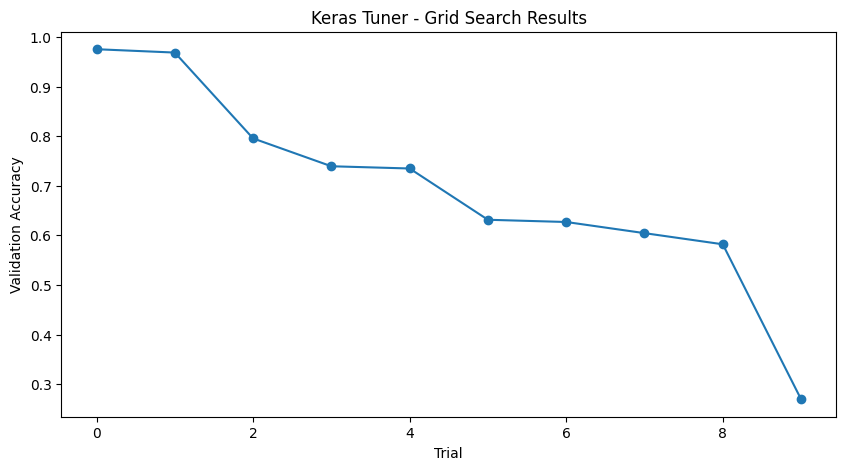

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Dropout, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from kerastuner.tuners import RandomSearch
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt

# ✅ Chuẩn bị dữ liệu (reshape để thêm chiều channel)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)

# ✅ Hàm xây dựng mô hình cho Keras Tuner
def build_model(hp):
    model = Sequential()

    # ✅ Tối ưu số lượng filters của Conv1D
    num_filters = hp.Choice('num_filters', [64, 128, 256, 512, 1024])

    # ✅ Tối ưu kernel size
    kernel_size = hp.Choice('kernel_size', [3, 5, 7])

    # ✅ Tối ưu số LSTM units
    lstm_units = hp.Choice('lstm_units', [64, 128, 256])

    # ✅ Tối ưu dropout
    dropout_rate = hp.Float('dropout_rate', 0.2, 0.5, step=0.1)

    # ✅ Tối ưu learning rate
    learning_rate = hp.Choice('learning_rate', [0.0001, 0.001, 0.01])

    # ✅ First Conv1D Block
    model.add(Conv1D(num_filters, kernel_size=kernel_size, strides=1, padding='same',
                     activation='relu', input_shape=(242, 1)))
    model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    # ✅ Second Conv1D Block
    model.add(Conv1D(num_filters // 2, kernel_size=kernel_size, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    # ✅ Third Conv1D Block
    model.add(Conv1D(num_filters // 4, kernel_size=kernel_size, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    # ✅ LSTM Layer
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))

    # ✅ Fully Connected Layers
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))

    # ✅ Output Layer (7 classes)
    model.add(Dense(7, activation='softmax'))

    # ✅ Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# ✅ Tính toán class weights
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, class_weights))

# ✅ Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# ✅ Tạo tuner với Random Search
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Số lần thử nghiệm khác nhau
    executions_per_trial=1,  # Số lần chạy mỗi thử nghiệm
    directory='keras_tuner_dir',
    project_name='speech_emotion_recognition'
)

# ✅ Tối ưu batch_size
batch_size_options = [32, 64, 128]

# ✅ Bắt đầu tìm kiếm hyperparameters
best_score = 0
best_model = None
best_batch_size = None

for batch_size in batch_size_options:
    tuner.search(x_train, y_train, epochs=30, validation_data=(x_val, y_val),
                 batch_size=batch_size, class_weight=class_weights_dict,
                 callbacks=[early_stopping, reduce_lr])

    # Lấy mô hình tốt nhất
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    tuned_model = tuner.hypermodel.build(best_hps)

    # Đánh giá trên tập validation
    _, val_acc = tuned_model.evaluate(x_val, y_val)

    if val_acc > best_score:
        best_score = val_acc
        best_model = tuned_model
        best_batch_size = batch_size

# ✅ In ra hyperparameters tốt nhất
print(f"\n🔍 Best Hyperparameters:")
print(f"Filters: {best_hps.get('num_filters')}")
print(f"Kernel Size: {best_hps.get('kernel_size')}")
print(f"LSTM Units: {best_hps.get('lstm_units')}")
print(f"Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")
print(f"Best Batch Size: {best_batch_size}")
print(f"Best Validation Accuracy: {best_score}")

# ✅ Vẽ biểu đồ kết quả Grid Search
def plot_tuner_results(tuner):
    trials = tuner.oracle.get_best_trials(num_trials=10)
    val_acc = [trial.metrics.get_best_value('val_accuracy') for trial in trials]
    params = [trial.hyperparameters.values for trial in trials]

    # Biểu đồ validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(val_acc)), val_acc, marker='o', linestyle='-')
    plt.xlabel("Trial")
    plt.ylabel("Validation Accuracy")
    plt.title("Keras Tuner - Grid Search Results")
    plt.show()

# ✅ Gọi hàm vẽ biểu đồ
plot_tuner_results(tuner)


In [ ]:
from tensorflow.keras.layers import Flatten
# Reshape the data to include the channel dimension
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1) #add this line

# Define the model
model = Sequential()

# First Conv1D Block
model.add(Conv1D(512, kernel_size=7, strides=1, padding='same', activation='relu', input_shape=(242, 1)))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Second Conv1D Block
model.add(Conv1D(256, kernel_size=7, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Third Conv1D Block
model.add(Conv1D(128, kernel_size=7, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# # LSTM Layers
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))
# model.add(LSTM(128, return_sequences=True))
# model.add(Dropout(0.3))
# model.add(LSTM(128))
# model.add(Dropout(0.3))

# Fully Connected Dense Layers
model.add(Flatten()) # add this line to flatten the output from the previous layers
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

# Output Layer (7 classes)
model.add(Dense(7, activation='softmax'))  # Assuming 6 emotion classes

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_30 (Conv1D)                   │ (None, 242, 512)            │           4,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_30 (MaxPooling1D)      │ (None, 121, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 121, 512)            │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_40 (Dropout)                 │ (None, 121, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_31 (Conv1D)                   │ (None, 121, 256)            │         917,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_31 (MaxPooling1D)      │ (None, 61, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 61, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ (None, 61, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_32 (Conv1D)                   │ (None, 61, 128)             │         229,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_32 (MaxPooling1D)      │ (None, 31, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 31, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 31, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 31, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ (None, 31, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 3968)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 128)                 │         508,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,805,127 (6.89 MB)

 Trainable params: 1,803,335 (6.88 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [ ]:
# Compute class weights
classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
print(class_weights)
class_weights_dict = dict(zip(classes, class_weights))

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
# checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_lr]
)

[0.99887514 0.99887514 1.00084531 1.00084531 1.00084531 0.99887514
 1.00084531]
Epoch 1/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.3459 - loss: 1.5597 - val_accuracy: 0.1306 - val_loss: 3.2874 - learning_rate: 0.0010
Epoch 2/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6446 - loss: 0.9135 - val_accuracy: 0.1418 - val_loss: 4.9372 - learning_rate: 0.0010
Epoch 3/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8044 - loss: 0.5220 - val_accuracy: 0.1306 - val_loss: 5.3387 - learning_rate: 0.0010
Epoch 4/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8949 - loss: 0.3079 - val_accuracy: 0.1381 - val_loss: 5.3990 - learning_rate: 0.0010
Epoch 5/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9197 - loss: 0.2146 - val_accuracy: 0.1679 - val_loss: 4.5966 - learning_rate: 0.0010
Epoch 6/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9505 - loss: 0.1542 - val_accuracy: 0.6754 - val_loss: 0.9981 - learning_rate: 0.0

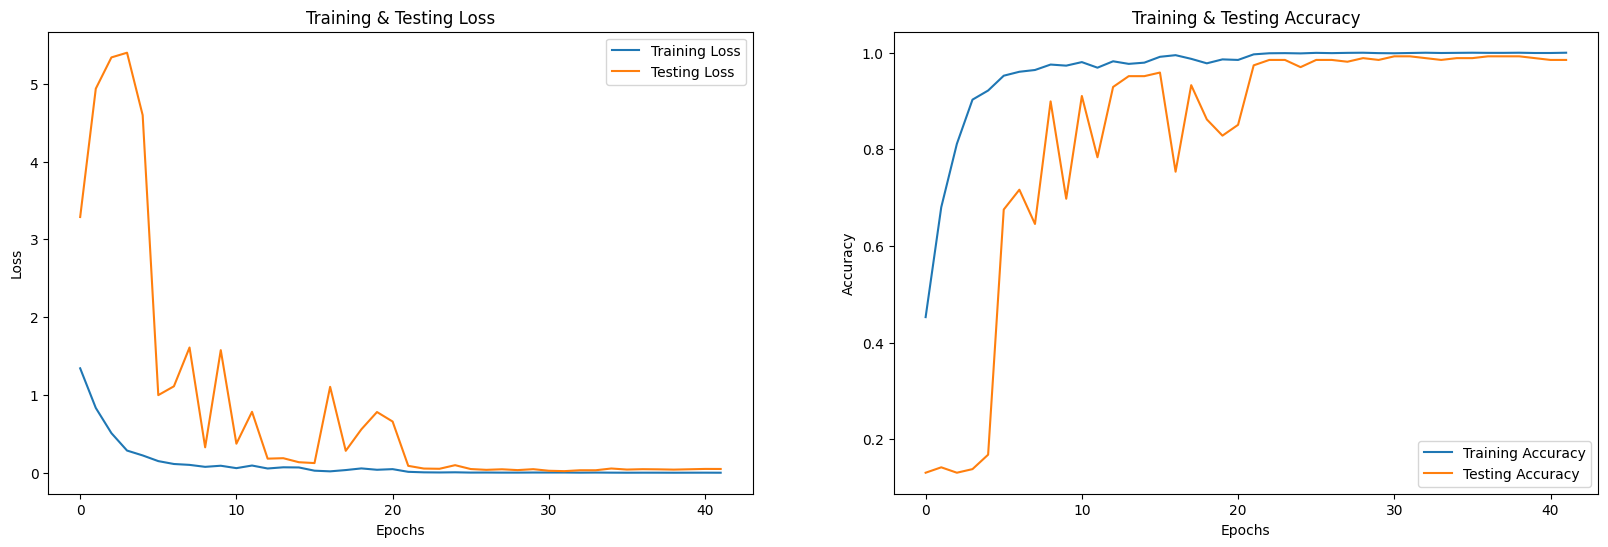

In [ ]:
# Dynamically generate the epochs array based on the training history
epochs = [i for i in range(len(history.history['loss']))]

# Create subplots
fig, ax = plt.subplots(1, 2)

# Extract metrics from the history object
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

# Set figure size
fig.set_size_inches(20, 6)

# Plot Training & Testing Loss
ax[0].plot(epochs, train_loss, label='Training Loss')
ax[0].plot(epochs, test_loss, label='Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

# Plot Training & Testing Accuracy
ax[1].plot(epochs, train_acc, label='Training Accuracy')
ax[1].plot(epochs, test_acc, label='Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")

# Show the plots
plt.show()

In [ ]:
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9924 - loss: 0.0190
test loss, test acc: [0.021182050928473473, 0.9925373196601868]


In [ ]:
pred_test = model.predict(x_test)
y_pred = np.argmax(pred_test, axis=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


In [ ]:
# Predict based on the test set
pred_test = model.predict(x_test)

# Convert the predicted probabilities to class labels
y_pred = np.argmax(pred_test, axis=1)

# Evaluate the F1-Score
f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class problems
print(f"F1-Score: {f1:.4f}")

# Optionally, print a detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
F1-Score: 0.9925

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        64
           1       1.00      1.00      1.00        41
           2       1.00      1.00      1.00        23
           3       0.97      1.00      0.99        34
           4       0.97      1.00      0.99        35
           5       1.00      1.00      1.00        40
           6       1.00      1.00      1.00        31

    accuracy                           0.99       268
   macro avg       0.99      1.00      0.99       268
weighted avg       0.99      0.99      0.99       268



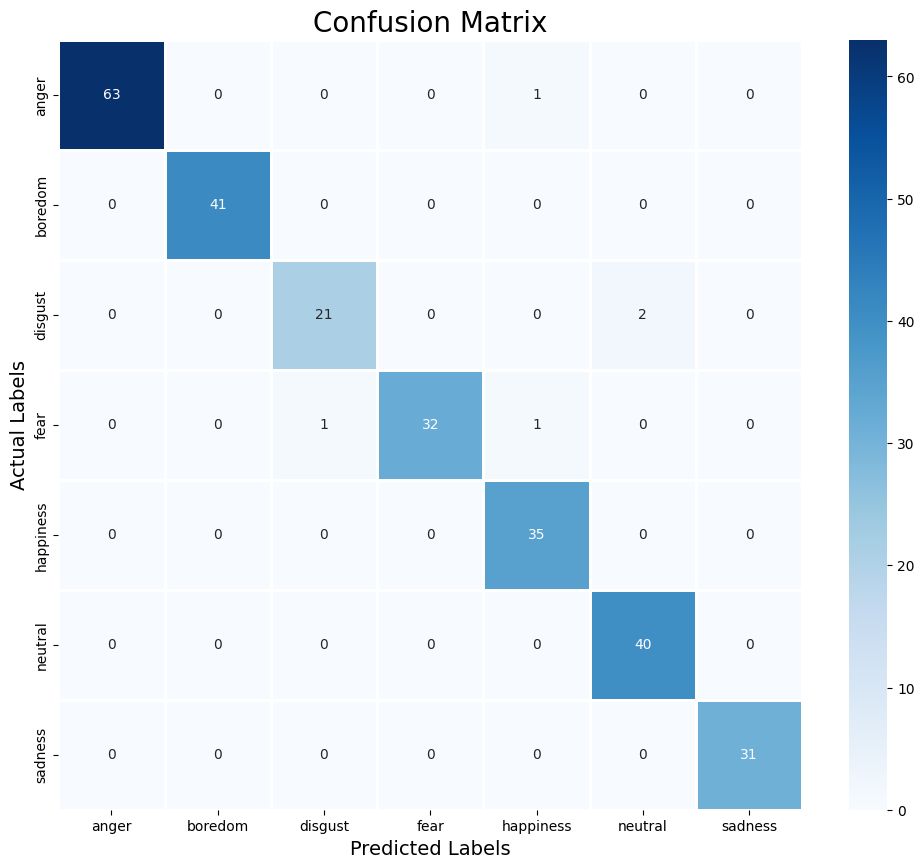

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()